# Sentiment Analysis of Android App Reviews

This notebook accompanies my MSc Data Science & Artificial Intelligence coursework for the module **CIS4515 – Practical Data Analysis (Coursework 2)**.

The goal is to:

1. Build a sentiment analysis pipeline for Amazon reviews of Android apps.
2. Compare several machine learning models (Naive Bayes, SVM, KNN, Decision Tree).
3. Use the best model’s predictions to estimate which Android Application Development (AAD) company has the highest average user sentiment.


## Imports/setup

In [1]:
# Core Libraries
import os
import sys
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

# --- FIX: Add the project root directory to sys.path ---
project_root = os.path.abspath("..")     # go up from notebooks/ to project root
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Now imports will work
from src.preprocess import load_datasets, preprocess_series
from src.utils import classification_metrics

## Load datasets

In [2]:
train_df, test_df = load_datasets(data_dir="../data")

train_df.head()


,Class Label,ID,Reviews_text
0,2,B004A9SDD8,"Loves the song, so he really couldn't wait to ..."
1,3,B004A9SDD8,"Oh, how my little grandson loves this app. He'..."
2,3,B004A9SDD8,I found this at a perfect time since my daught...
3,3,B004A9SDD8,My 1 year old goes back to this game over and ...
4,3,B004A9SDD8,There are three different versions of the song...


## Dataset Overview

We start by inspecting the size of the training and test sets and the distribution of sentiment labels.


In [3]:
print("Training shape:", train_df.shape)
print("Test shape:", test_df.shape)

train_df["Class Label"].value_counts().sort_index()
test_df["Class Label"].value_counts().sort_index()


Training shape: (20001, 3)
Test shape: (19999, 3)


Class Label
1     3469
2     2087
3    14443
Name: count, dtype: int64

## Visualise class distribution

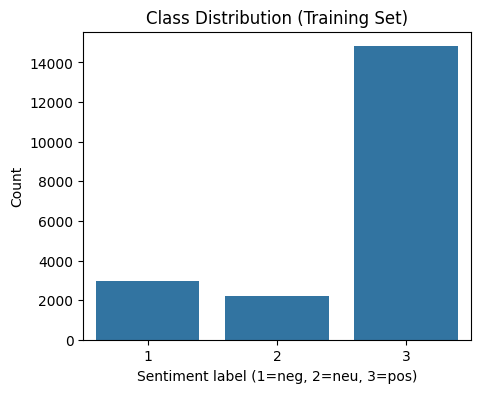

In [4]:
plt.figure(figsize=(5, 4))
sns.countplot(x="Class Label", data=train_df)
plt.title("Class Distribution (Training Set)")
plt.xlabel("Sentiment label (1=neg, 2=neu, 3=pos)")
plt.ylabel("Count")
plt.show()


## Word cloud of reviews

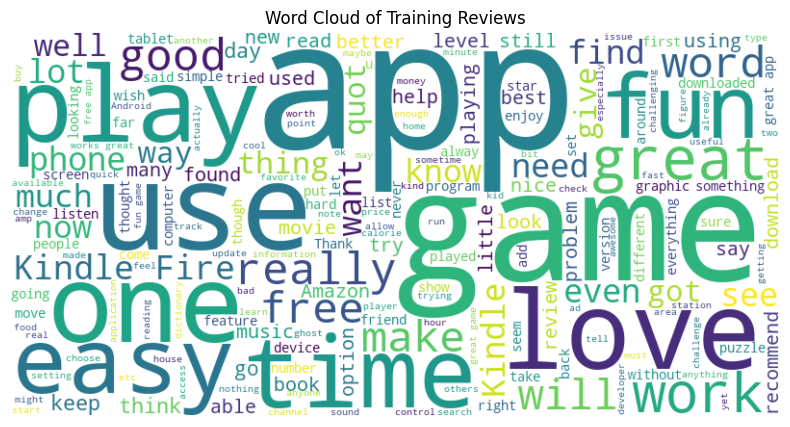

In [5]:
all_text = " ".join(train_df["Reviews_text"].astype(str).tolist())
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Training Reviews")
plt.show()


## Preprocess text

In [6]:
train_clean = preprocess_series(train_df["Reviews_text"])
test_clean = preprocess_series(test_df["Reviews_text"])

train_clean.head()


0    loves the song so he really couldn t wait to p...
1    oh how my little grandson loves this app he s ...
2    i found this at a perfect time since my daught...
3    my year old goes back to this game over and ov...
4    there are three different versions of the song...
Name: Reviews_text, dtype: object

## Feature Extraction and Model Training

We convert the cleaned text into TF–IDF features and train four models:

- Multinomial Naive Bayes
- Linear SVM
- K-Nearest Neighbours
- Decision Tree


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

# Vectorise text
vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1, 2))
X_train = vectorizer.fit_transform(train_clean)
X_test = vectorizer.transform(test_clean)

y_train = train_df["Class Label"]
y_test = test_df["Class Label"]

models = {
    "naive_bayes": MultinomialNB(),
    "svm": LinearSVC(),
    "knn": KNeighborsClassifier(n_neighbors=5),
    "decision_tree": DecisionTreeClassifier(random_state=42),
}

trained_models = {}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    trained_models[name] = model


Training naive_bayes...
Training svm...
Training knn...
Training decision_tree...


## Model Evaluation

We evaluate each model using accuracy, precision, recall and F1-score (weighted average).


In [8]:
results = []

for name, model in trained_models.items():
    y_pred = model.predict(X_test)
    metrics = classification_metrics(y_test, y_pred)
    metrics["model"] = name
    results.append(metrics)

results_df = pd.DataFrame(results).set_index("model")
results_df


,accuracy,precision,recall,f1
model,,,,
naive_bayes,0.756838,0.759275,0.756838,0.678671
svm,0.813591,0.789416,0.813591,0.797022
knn,0.750938,0.693575,0.750938,0.704173
decision_tree,0.697935,0.689071,0.697935,0.693158


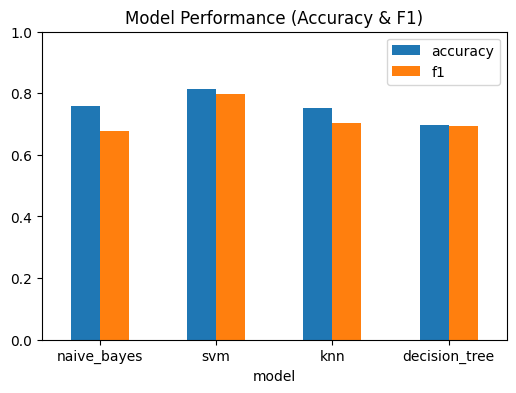

In [9]:
results_df[["accuracy", "f1"]].plot(kind="bar", figsize=(6,4))
plt.title("Model Performance (Accuracy & F1)")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.show()


## Company-Level Sentiment Analysis (Using SVM)

Using the best-performing model (SVM), we predict sentiment for the test reviews and compute the
average sentiment score (1=negative, 2=neutral, 3=positive) for each AAD company.


In [10]:
# App ID → Company mapping
APP_COMPANIES = {
    "B004NWLM8K": "AAD_1",
    "B004Q1NH4U": "AAD_1",
    "B004LPBTAA": "AAD_1",
    "B004S6NAOU": "AAD_2",
    "B004R6HTWU": "AAD_2",
    "B004N8KDNY": "AAD_2",
    "B004KA0RBS": "AAD_3",
    "B004NPELDA": "AAD_3",
    "B004L26XXQ": "AAD_3",
}

svm_model = trained_models["svm"]
svm_preds = svm_model.predict(X_test)

test_with_preds = test_df.copy()
test_with_preds["Predicted_Label"] = svm_preds
test_with_preds["Company"] = test_with_preds["ID"].map(APP_COMPANIES)
test_with_preds = test_with_preds.dropna(subset=["Company"])

company_scores = (
    test_with_preds.groupby("Company")["Predicted_Label"]
    .mean()
    .sort_values(ascending=False)
)

company_scores


Company
AAD_1    2.943925
AAD_2    2.273649
AAD_3    1.952381
Name: Predicted_Label, dtype: float64

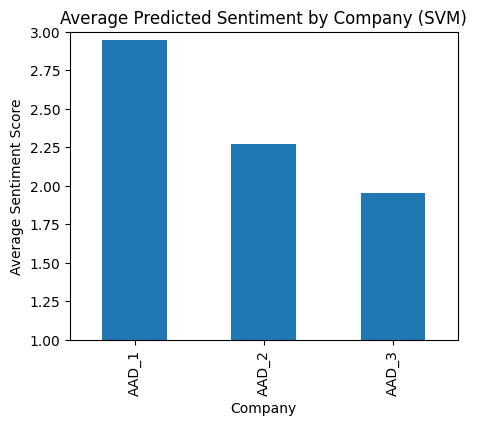

In [11]:
company_scores.plot(kind="bar", figsize=(5,4))
plt.ylabel("Average Sentiment Score")
plt.title("Average Predicted Sentiment by Company (SVM)")
plt.ylim(1, 3)
plt.show()


## Conclusion

- The **SVM model** achieved the best overall performance on the test set (highest accuracy and F1-score).
- Average sentiment scores from SVM predictions indicate that:

  - **AAD_1** has the most positive user sentiment.
  - **AAD_2** is in the middle.
  - **AAD_3** has the lowest sentiment.

These results are consistent with the findings reported in the formal coursework report and demonstrate an end-to-end sentiment analysis workflow from raw reviews to business-level insight.
